# Character-level next-character prediction — RNN vs LSTM
***A short project to see how simple recurrent nets (vanilla RNN) and LSTMs remember sequences and predict the next character.***


# 1. Imports & settings
***Short: import required libs and set reproducibility***

In [20]:
# 1. Imports & settings
# Short: import required libs and set reproducibility
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [21]:
import pandas as pd

# Load plain text file line by line
url = "Datasets/cleaned_merged_fairy_tales_without_eos.txt"

with open(url, "r", encoding="utf-8") as f:
    lines = f.read().splitlines()

df = pd.DataFrame(lines, columns=["text"])
df.head()


,text
0,The Happy Prince.
1,"HIGH above the city, on a tall column, stood t..."
2,He was very much admired indeed. “He is as be...
3,“Why can’t you be like the Happy Prince?” aske...
4,“I am glad there is some one in the world who ...


## 2. Load text data (we already created df with one line per entry)
***Short: join lines into one large corpus and sample a subset for speed***


In [22]:
# assume df already exists (from previous cell): df = pd.DataFrame(lines, columns=["text"])
corpus = "\n".join(df['text'].astype(str).tolist())  # full corpus
# optional: use a shorter slice for quick experiments
max_chars = 200000   # reduce if you want faster runs
corpus = corpus[:max_chars]
print("Corpus length:", len(corpus))
print("Example snippet:", corpus[:200].replace("\n","⏎"))


Corpus length: 200000
Example snippet: The Happy Prince.⏎HIGH above the city, on a tall column, stood the statue of the Happy Prince.  He was gilded all over with thin leaves of fine gold, for eyes he had two bright sapphires, and a large 


## 3. Build vocabulary & mapping
***Short: map each unique character to an integer id and back***


In [23]:
chars = sorted(list(set(corpus)))
vocab_size = len(chars)
char2idx = {c:i for i,c in enumerate(chars)}
idx2char = {i:c for i,c in enumerate(chars)}
print("Vocab size:", vocab_size)


Vocab size: 80


## 4. Create training sequences (input seq → next char)
***Short: sliding-window character sequences; convert to integer arrays***


In [24]:
seq_len = 40   # input length in chars
step = 3       # step size for sliding window
sentences = []
next_chars = []
for i in range(0, len(corpus)-seq_len, step):
    sentences.append(corpus[i: i+seq_len])
    next_chars.append(corpus[i+seq_len])
print("Number of sequences:", len(sentences))

# vectorize
X = np.zeros((len(sentences), seq_len), dtype=np.int32)
y = np.zeros((len(sentences),), dtype=np.int32)
for i, sentence in enumerate(sentences):
    X[i] = [char2idx[c] for c in sentence]
    y[i] = char2idx[next_chars[i]]

Number of sequences: 66654


## 5. Prepare datasets (one-hot input for Keras Embedding optional)
***Short: use an Embedding + sparse categorical labels for efficiency***


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=SEED, shuffle=True)
n_train = X_train.shape[0]
print("Train / Val sizes:", n_train, X_val.shape[0])


Train / Val sizes: 56655 9999


## 6. Model builder helper
***Short: reusable build function for RNN and LSTM models (uses Embedding)***


In [26]:
def build_seq_model(cell_type='RNN', embedding_dim=32, rnn_units=64, lr=0.001):
    inp = layers.Input(shape=(seq_len,), dtype='int32')
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_len)(inp)
    if cell_type == 'RNN':
        x = layers.SimpleRNN(rnn_units)(x)
    elif cell_type == 'LSTM':
        x = layers.LSTM(rnn_units)(x)
    else:
        raise ValueError("cell_type must be 'RNN' or 'LSTM'")
    out = layers.Dense(vocab_size, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


## 7. Train vanilla RNN (small quick run)
***Short: train a SimpleRNN model and save history***


In [27]:
rnn_model = build_seq_model(cell_type='RNN', embedding_dim=32, rnn_units=64, lr=0.001)
rnn_model.summary()
rnn_hist = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=10, batch_size=128, verbose=1)


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 40, 32)         │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │         5,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,968 (54.56 KB)

 Trainable params: 13,968 (54.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.2572 - loss: 2.8243 - val_accuracy: 0.3151 - val_loss: 2.4781
Epoch 2/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.3365 - loss: 2.3717 - val_accuracy: 0.3489 - val_loss: 2.3078
Epoch 3/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3670 - loss: 2.2321 - val_accuracy: 0.3752 - val_loss: 2.2032
Epoch 4/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3922 - loss: 2.1389 - val_accuracy: 0.3983 - val_loss: 2.1324
Epoch 5/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.4090 - loss: 2.0716 - val_accuracy: 0.4120 - val_loss: 2.0797
Epoch 6/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4206 - loss: 2.0194 - val_accuracy: 0.4215 - val_loss: 2.0372
Epoch 7/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4310 - loss: 1.9772 - val_accuracy: 0.4313 - val_loss: 2.0030
Epoch 8/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4398 - loss: 1.9422 - val_acc

## 8. Train LSTM (same capacity) — compare directly
***Short: train an LSTM with similar parameter count***


In [28]:
lstm_model = build_seq_model(cell_type='LSTM', embedding_dim=32, rnn_units=64, lr=0.001)
lstm_hist = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                          epochs=10, batch_size=128, verbose=1)


Epoch 1/10


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


443/443 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.2423 - loss: 2.9099 - val_accuracy: 0.3121 - val_loss: 2.5807
Epoch 2/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.3179 - loss: 2.4755 - val_accuracy: 0.3275 - val_loss: 2.4037
Epoch 3/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.3346 - loss: 2.3357 - val_accuracy: 0.3432 - val_loss: 2.3044
Epoch 4/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.3565 - loss: 2.2474 - val_accuracy: 0.3667 - val_loss: 2.2354
Epoch 5/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.3754 - loss: 2.1826 - val_accuracy: 0.3780 - val_loss: 2.1818
Epoch 6/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.3879 - loss: 2.1314 - val_accuracy: 0.3909 - val_loss: 2.1393
Epoch 7/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.3984 - loss: 2.0902 - val_accuracy: 0.4022 - val_loss: 2.1043
Epoch 8/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.4086 - loss: 2.0552 - val_accuracy:

## 9. Plot training & validation accuracy / loss
***Short: visualize learning curves to compare speed and generalization***


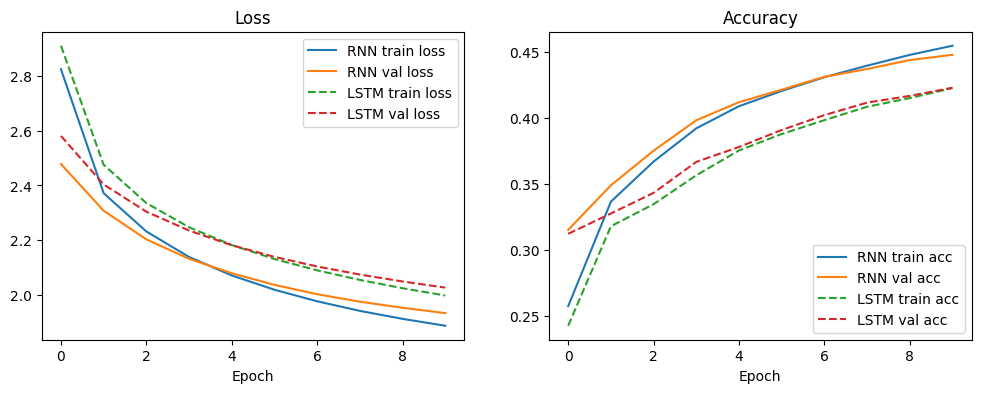

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(rnn_hist.history['loss'], label='RNN train loss')
plt.plot(rnn_hist.history['val_loss'], label='RNN val loss')
plt.plot(lstm_hist.history['loss'], '--', label='LSTM train loss')
plt.plot(lstm_hist.history['val_loss'], '--', label='LSTM val loss')
plt.legend(); plt.title("Loss"); plt.xlabel("Epoch")

plt.subplot(1,2,2)
plt.plot(rnn_hist.history['accuracy'], label='RNN train acc')
plt.plot(rnn_hist.history['val_accuracy'], label='RNN val acc')
plt.plot(lstm_hist.history['accuracy'], '--', label='LSTM train acc')
plt.plot(lstm_hist.history['val_accuracy'], '--', label='LSTM val acc')
plt.legend(); plt.title("Accuracy"); plt.xlabel("Epoch")
plt.show()


## 10. Simple sampling function — generate text to inspect predictions
***Short: see qualitative difference: give a seed and sample next chars***


In [30]:
def sample_next(model, seed_text, temperature=1.0, n_chars=100):
    seq = seed_text[-seq_len:]
    generated = seed_text
    for _ in range(n_chars):
        x = np.array([[char2idx.get(c,0) for c in seq]])
        preds = model.predict(x, verbose=0)[0]
        # apply temperature
        preds = np.log(np.maximum(preds, 1e-12)) / temperature
        exp_preds = np.exp(preds)
        probs = exp_preds / np.sum(exp_preds)
        next_idx = np.random.choice(range(vocab_size), p=probs)
        next_char = idx2char[next_idx]
        generated += next_char
        seq = (seq + next_char)[-seq_len:]
    return generated

seed = corpus[:seq_len]
print("RNN sample:\n", sample_next(rnn_model, seed, temperature=0.8, n_chars=200))
print("\nLSTM sample:\n", sample_next(lstm_model, seed, temperature=0.8, n_chars=200))


RNN sample:
 The Happy Prince.
HIGH above the city, onounce tio will fleck finold and would led the heavery wan comped ap; that so matimamanking the in a pimtcered asoutifters ablow ole hooked.”
“I I malo-bly ould porbsce, har of to intt store to inethi

LSTM sample:
 The Happy Prince.
HIGH above the city, on as I paim the gormen in wat the con thowe, yowhing.
This ant ousror-tother. Onle anceld a sifired and treen lacting a mouly non op baclot of sone is the parusared. “had I pamm the prow brow it wing 


## 11. Quick quantitative comparison on validation set
***Short: evaluate both models on validation set and compare loss/accuracy***


In [31]:
rnn_eval = rnn_model.evaluate(X_val, y_val, verbose=0)
lstm_eval = lstm_model.evaluate(X_val, y_val, verbose=0)
print("RNN  - val_loss: {:.4f}, val_acc: {:.4f}".format(*rnn_eval))
print("LSTM - val_loss: {:.4f}, val_acc: {:.4f}".format(*lstm_eval))


RNN  - val_loss: 1.9340, val_acc: 0.4480
LSTM - val_loss: 2.0271, val_acc: 0.4230


## 12. Short reflection (write-up cell)
***Short: guidance on what to expect and why differences occur***


**Reflection:**  
- **Speed:** Vanilla RNNs are typically faster per epoch than LSTMs because LSTMs have more internal gates and parameters.  
- **Accuracy / Memory:** LSTMs usually outperform vanilla RNNs on sequence tasks that require longer-range memory (they avoid vanishing gradients).  
- **Preprocessing:** Both used integer encoding + Embedding here; more complex preprocessing (one-hot, normalization) is less critical for char-level tasks.  
- **Model complexity & overfitting:** Increasing layers/units can improve fit but risks overfitting — watch train vs val loss curves and use dropout/regularization or early stopping.  
- **Tip for beginners:** Start small (short seq_len, few units, few epochs). Once code runs, increase model size and training time gradually while monitoring validation performance.
